<a href="https://colab.research.google.com/github/MalikArslanBashir/Data-Science-Tasks/blob/main/Mini_project_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Denoising

**An application of autoencoders includes image denoising. For this part I'll be using the person dataset that is a subset of the COCO dataset. You can download the datset using this link (https://drive.google.com/file/d/1gHTLS6dvEp31X2dWBdLrvGr--5WOm1Z3/view?usp=sharing). I'll use the images present in the dataset and generate my own labels through adding salt and pepper noise to the image. Given input to the model will be the noisy image created through using functions from opencv library and output will be the original image.**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import zipfile
import io
import os

In [5]:
extracted_path = '/content/drive/MyDrive/Data_Science/Persons_dataset'
original_image=[]
noisy_image=[]
for root, dirs, files in os.walk(extracted_path):
    for filename in files:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(root, filename)
            original_img = cv2.imread(image_path)
            original_image.append(original_img)
        def preprocess_image(image, desired_width, desired_height):
            img = cv2.resize(image, (desired_width, desired_height))
            img = img.astype('float32') / 255.0
            return img
        img = preprocess_image(original_img, desired_width=64, desired_height=64)
        original_image.append(img)
        noise_img = img.copy()
        p = 0.05
        salt_vs_pepper = 0.5
        amount = 0.04
        num_salt = np.ceil(amount * noise_img.size * p)
        num_pepper = np.ceil(amount * noise_img.size * (1.0 - p))
        salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in noise_img.shape]
        noise_img[salt_coords[0], salt_coords[1], :] = 255
        pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in noise_img.shape]
        noise_img[pepper_coords[0], pepper_coords[1], :] = 0
        noisy_image.append(noise_img)

In [6]:
grayscale_original_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in original_image]
grayscale_noisy_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in noisy_image]
grayscale_noisy_images = np.pad(grayscale_noisy_images, (0, 1000), 'constant')
print("Grayscale Noisy Images length:", len(grayscale_noisy_images))
print("Grayscale Original Images length:", len(grayscale_original_images))

Grayscale Noisy Images length: 2000
Grayscale Original Images length: 2000


In [ ]:
from sklearn.model_selection import train_test_split
noisy_train, noisy_test, original_train, original_test = train_test_split(grayscale_noisy_images, grayscale_original_images, test_size=0.2, random_state=42)
noisy_test, noisy_val, original_test, original_val = train_test_split(noisy_test, original_test, test_size=0.5, random_state=42)
print("Noisy Train length:", len(noisy_train))
print("Noisy Validation length:", len(noisy_val))
print("Noisy Test length:", len(noisy_test))
noisy_train = np.array(noisy_train)
original_train = np.array(original_train)
noisy_val = np.array(noisy_val)
original_val = np.array(original_val)
noisy_test=np.array(noisy_test)
original_test=np.array(original_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

input_shape = (64, 64, 1)

input_img = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = autoencoder.fit(
    noisy_train, original_train,
    epochs=10, batch_size=32,
    validation_data=(noisy_val, original_val)
)


Epoch 1/10
250/250 [==============================] - 889s 4s/step - loss: 0.0817 - val_loss: 0.0635
Epoch 2/10
250/250 [==============================] - 815s 3s/step - loss: 0.0416 - val_loss: 0.0305
Epoch 3/10
250/250 [==============================] - 973s 4s/step - loss: 0.0268 - val_loss: 0.0159
Epoch 4/10
250/250 [==============================] - 1029s 4s/step - loss: 0.0149 - val_loss: 0.0138
Epoch 5/10
250/250 [==============================] - 1062s 4s/step - loss: 0.0136 - val_loss: 0.0133
Epoch 6/10
250/250 [==============================] - 8322s 33s/step - loss: 0.0130 - val_loss: 0.0125
Epoch 7/10
250/250 [==============================] - 765s 3s/step - loss: 0.0125 - val_loss: 0.0119
Epoch 8/10
250/250 [==============================] - 805s 3s/step - loss: 0.0121 - val_loss: 0.0116
Epoch 9/10
250/250 [==============================] - 777s 3s/step - loss: 0.0117 - val_loss: 0.0114
Epoch 10/10
250/250 [==============================] - 734s 3s/step - loss: 0.0114 - va

In [ ]:
original_pred=autoencoder.predict(noisy_test[0:])


32/32 [==============================] - 34s 1s/step


In [ ]:
loss=autoencoder.evaluate(original_test,original_pred)

32/32 [==============================] - 34s 1s/step - loss: 0.0021


1/1 [==============================] - 0s 255ms/step


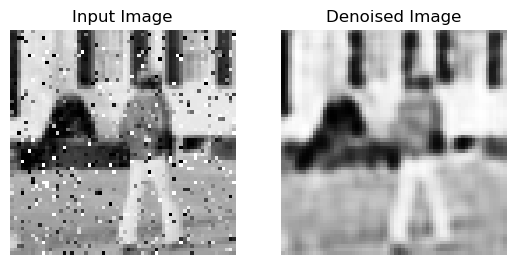

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = 'C:\\Users\\KTG\\Desktop\\Grey-scale-image-corrupted-with-salt-and-pepper-noise-which-is-used-for-training-the-HNN.png'
noisy_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


input_img = cv2.resize(noisy_img, (64, 64))
input_img = input_img / 255.0

plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_img, cmap='gray')
plt.axis('off')

denoised_img = autoencoder.predict(np.array([input_img.reshape(64, 64, 1)]))
denoised_img = np.squeeze(denoised_img, axis=0)

plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_img, cmap='gray')
plt.axis('off')

plt.show()
